## Importemos las librerias

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')      # WordNet en inglés
nltk.download('omw-1.4')      # WordNet multilingüe (posible cobertura parcial en español)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
import requests
from bs4 import BeautifulSoup
import re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt
import numpy as np


In [10]:
url = "https://es.wikipedia.org/wiki/Sistema_complejo"

try:
    # Descargar el contenido HTML de la página
    response = requests.get(url)
    # Verificar estatus de la respuesta
    if response.status_code == 200:
        html_content = response.text
    else:
        raise Exception(f"Error al descargar la página: Status code {response.status_code}")

    # Parsear HTML con BeautifulSoup
    soup = BeautifulSoup(html_content, "lxml")

    # Extraer todo el texto dentro de etiquetas <p>, <h1>, <h2>, etc.
    # (Aquí puedes adaptar según tus necesidades; eliminamos tags de script, style, etc.)
    for script in soup(["script", "style", "table", "img", "sup", "span", "b", "i"]):
        script.extract()

    # Quedarnos con el texto plano principal
    text_content = ""
    for element in soup.find_all(["p", "h1", "h2", "h3", "h4"]):
        text_content += element.get_text() + "\n"

    # Limpieza básica: eliminar espacios y saltos innecesarios
    text_content = re.sub(r'\s+', ' ', text_content)
    text_content = text_content.strip()

    print("Texto descargado y limpiado con éxito.")
except Exception as e:
    print("Ocurrió un error al descargar o limpiar el texto:")
    print(str(e))
    text_content = ""  # En caso de error, ponemos el texto vacío para que no rompa más adelante


Texto descargado y limpiado con éxito.


In [14]:
pattern = r'''(?x)                 # Flag para iniciar el modo verbose
              (?:[A-Z]\.)+         # Hace match con abreviaciones como U.S.A.
              | \w+(?:-\w+)*       # Hace match con palabras que pueden tener un guión interno
              | \$?\d+(?:\.\d+)?%? # Hace match con dinero o porcentajes como $15.5 o 100%
              | \.\.\.             # Hace match con puntos suspensivos
              | [][.,;"'?():-_`]   # Hace match con signos de puntuación
'''
tokens = nltk.regexp_tokenize(text_content,pattern)

In [15]:
# Pasamos a minúsculas
tokens_lower = [t.lower() for t in tokens]

# Definimos signos de puntuación (puedes ampliarlo)
puntuacion = set([".", ",", ";", ":", "¡", "!", "¿", "?", "(", ")", "[", "]", "«", "»", "''", '``', "'"])

# Stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Filtramos tokens
tokens_cleaned = [
    t for t in tokens_lower
    if t not in puntuacion 
    and t not in stopwords_es 
    and t.isalpha()  # nos aseguramos de que sea texto alfabético
]

print("\nEjemplo de tokens limpios:", tokens_cleaned[:30], "...")


Ejemplo de tokens limpios: ['contenidos', 'compuestos', 'redes', 'multilayer', 'múltiples', 'capas', 'decir', 'interacciones', 'elementos', 'redes', 'cambian', 'forma', 'interdependiente', 'largo', 'tiempo', 'interacciones', 'solo', 'generan', 'comportamientos', 'emergentes', 'inesperados', 'sino', 'producen', 'información', 'adicional', 'derivada', 'dinámica', 'conjunta', 'componentes', 'imposible'] ...


In [16]:
bigram_measures = BigramAssocMeasures()
finder_bi = BigramCollocationFinder.from_words(tokens_cleaned)
# Podemos filtrar bigramas poco frecuentes
finder_bi.apply_freq_filter(2)
# Extraer n mejores bigramas según la métrica de asociación (PMI o t-score)
top_10_bigrams = finder_bi.nbest(bigram_measures.pmi, 10)
print("\nTop 10 bigramas encontrados:", top_10_bigrams)

# TRIGRAMAS
trigram_measures = TrigramAssocMeasures()
finder_tri = TrigramCollocationFinder.from_words(tokens_cleaned)
finder_tri.apply_freq_filter(2)
top_10_trigrams = finder_tri.nbest(trigram_measures.pmi, 10)
print("Top 10 trigramas encontrados:", top_10_trigrams)


Top 10 bigramas encontrados: [('conjunto', 'ejemplos'), ('tira', 'afloja'), ('comportamientos', 'colectivos'), ('suma', 'cero'), ('juego', 'suma'), ('jugador', 'i'), ('escala', 'tiempo'), ('sistema', 'complejo'), ('sistema', 'conjunto'), ('sistema', 'interactúa')]
Top 10 trigramas encontrados: [('juego', 'suma', 'cero'), ('sistema', 'conjunto', 'ejemplos'), ('propiedades', 'sistemas', 'complejos'), ('estudio', 'sistemas', 'complejos')]



Pendiente (slope) de la regresión log-log: -0.4549
Intersección (intercept) de la regresión log-log: 1.0982


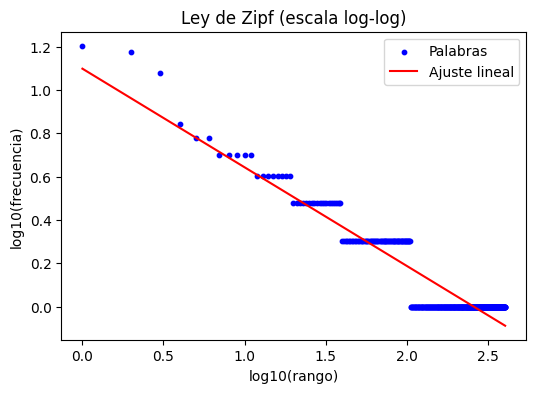

In [17]:
# Calculamos frecuencia de cada palabra
freq_dist = nltk.FreqDist(tokens_cleaned)

# Ordenamos por frecuencia descendente
sorted_freq = freq_dist.most_common()
words = [w for w, f in sorted_freq]
counts = [f for w, f in sorted_freq]

# Vamos a verificar si se cumple aproximadamente la Ley de Zipf
# rank ~ 1, 2, 3, ...
ranks = np.arange(1, len(counts) + 1)
freqs = np.array(counts)

# Aplicamos log10 a rank y frec
log_ranks = np.log10(ranks)
log_freqs = np.log10(freqs)

# Ajuste lineal (regresión) en la escala log-log
slope, intercept = np.polyfit(log_ranks, log_freqs, 1)
print(f"\nPendiente (slope) de la regresión log-log: {slope:.4f}")
print(f"Intersección (intercept) de la regresión log-log: {intercept:.4f}")

# Gráfica para visualizar la Ley de Zipf
plt.figure(figsize=(6,4))
plt.scatter(log_ranks, log_freqs, s=10, c='blue', label='Palabras')
plt.plot(log_ranks, intercept + slope*log_ranks, color='red', label='Ajuste lineal')
plt.title("Ley de Zipf (escala log-log)")
plt.xlabel("log10(rango)")
plt.ylabel("log10(frecuencia)")
plt.legend()
plt.show()


Top 20 palabras más frecuentes: ['sistemas', 'sistema', 'complejos', 'interacciones', 'estudio', 'límites', 'elementos', 'forma', 'tiempo', 'juego', 'pueden', 'información', 'propiedades', 'cada', 'tierra', 'ecuaciones', 'condiciones', 'i', 'escala', 'decir']


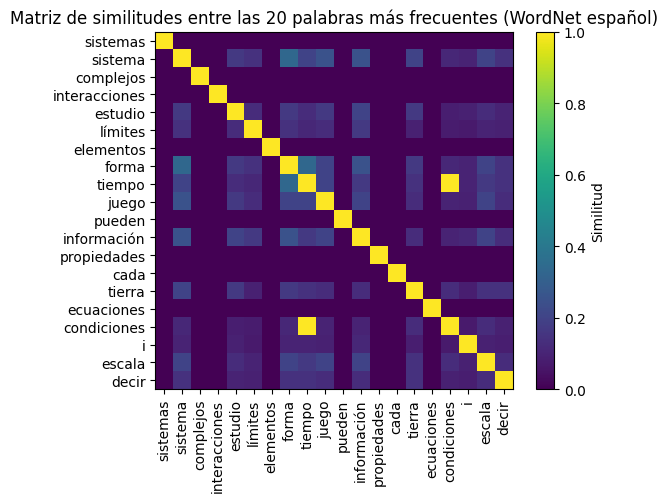

In [18]:
top_20_words = words[:20]
print("\nTop 20 palabras más frecuentes:", top_20_words)

# Función para obtener el valor máximo de similitud de path
# entre las definiciones (synsets) de dos palabras en español (si las hay).
def get_max_similarity_es(word1, word2):
    # Obtenemos synsets en español, si existen
    synsets1 = wn.synsets(word1, lang='spa')
    synsets2 = wn.synsets(word2, lang='spa')
    
    if not synsets1 or not synsets2:
        return 0.0  # Si no hay synsets, similitud 0
    
    max_sim = 0.0
    for s1 in synsets1:
        for s2 in synsets2:
            sim = s1.path_similarity(s2)
            if sim is not None and sim > max_sim:
                max_sim = sim
    return max_sim

# Creamos una matriz de similitudes de 20x20
sim_matrix = np.zeros((20, 20))

for i in range(20):
    for j in range(20):
        if i == j:
            sim_matrix[i, j] = 1.0
        else:
            sim_matrix[i, j] = get_max_similarity_es(top_20_words[i], top_20_words[j])

# Mostramos la matriz de similitud como imagen
plt.figure(figsize=(6,5))
plt.imshow(sim_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Similitud")
plt.xticks(range(20), top_20_words, rotation=90)
plt.yticks(range(20), top_20_words)
plt.title("Matriz de similitudes entre las 20 palabras más frecuentes (WordNet español)")
plt.tight_layout()
plt.show()